Capstone Project EDA - Nadia Morgen

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
plt.style.use('fivethirtyeight')

# Data Imports

In [3]:
flight_posted = pd.read_csv('data/flight_posted.csv')
flight_actl = pd.read_csv('data/flight_actl.csv')

# Flight of Passage

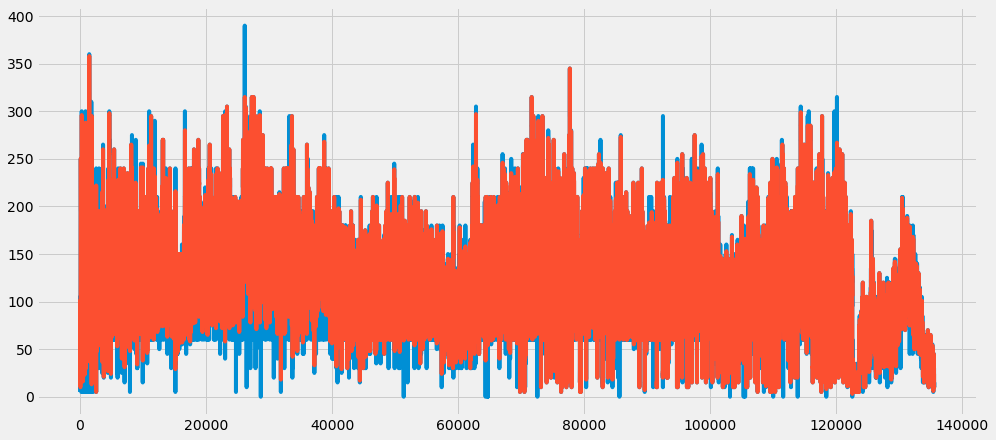

In [4]:
plt.figure(figsize = (15, 7))
plt.plot(flight_posted['SPOSTMIN'])
plt.plot(flight_posted['SPOSTMIN'].rolling(5).mean());


The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

In any case the rolling means of posted waiting times and posted waiting times overlap highly.

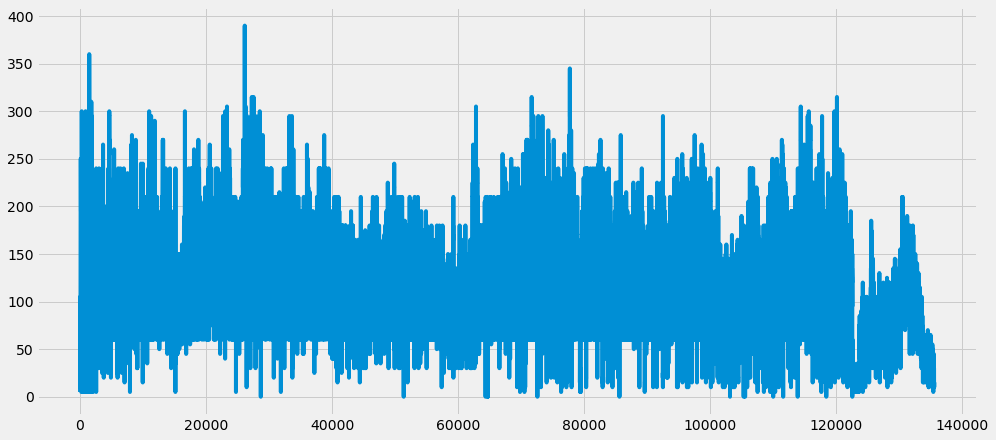

In [5]:
plt.figure(figsize = (15, 7))
plt.plot(flight_posted['SPOSTMIN']);

In [6]:
flight_posted['SPOSTMIN'].min()

0.0

In [7]:
flight_posted['SPOSTMIN'].max()

390.0

In [8]:
# Start calculating average wait time by day
flight_posted.head(2)

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday
1,2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday


In [9]:
flight_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

Apparently, I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [10]:
flight_posted['date'] = pd.to_datetime(flight_posted['date'])
flight_posted['datetime'] = pd.to_datetime(flight_posted['datetime'])
flight_posted['day_name'] = flight_posted.day_name.astype('string')

flight_actl['date'] = pd.to_datetime(flight_actl['date'])
flight_actl['datetime'] = pd.to_datetime(flight_actl['datetime'])


flight_posted.set_index('date', inplace = True)
flight_actl.set_index('date', inplace = True)

In [11]:
flight_posted['avg_daily_posted_wait'] = flight_posted.groupby('date')['SPOSTMIN'].mean()

In [12]:
flight_posted.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:24:07,NaN,60.0,5,Friday,45.866667


In [13]:
# Calculate waiting time over the course of one day
av_daily_wait = flight_posted.drop(columns=['SACTMIN', 'SPOSTMIN', 'datetime'])

In [14]:
# Get rid of duplicates for readability

av_daily_wait.drop_duplicates(subset=None, keep='first', inplace=True)

In [15]:
av_daily_wait.head()

,weekday,day_name,avg_daily_posted_wait
date,,,
2017-05-26,5,Friday,45.866667
2017-05-27,6,Saturday,196.302521
2017-05-28,7,Sunday,190.689655
2017-05-29,1,Monday,141.744186
2017-05-30,2,Tuesday,154.160305


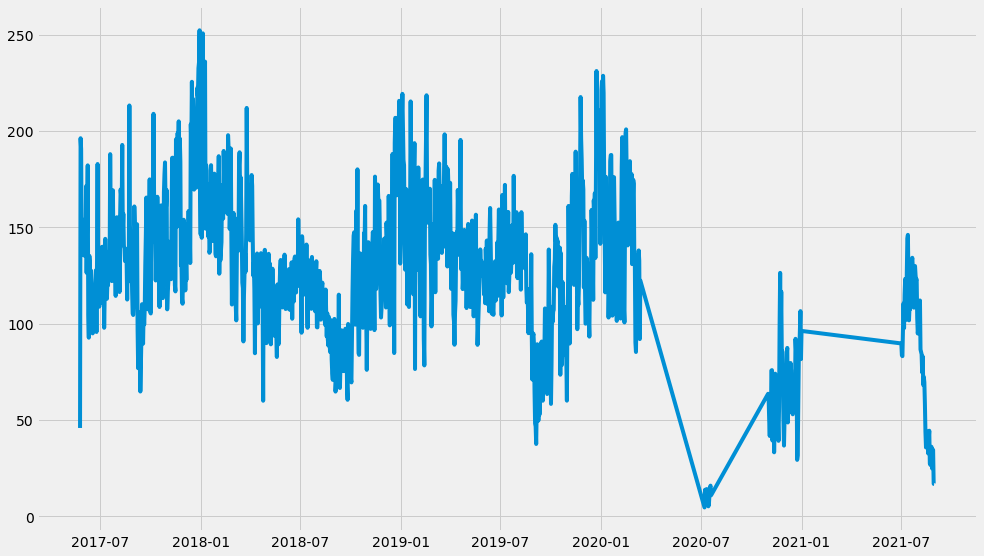

In [16]:
plt.figure(figsize = (15, 9))
plt.plot(av_daily_wait['avg_daily_posted_wait'], label='Average Daily Wait Time Since flight River Opened');

In [17]:
#flight_posted['avg_daily_posted_wait'] = flight_posted.groupby('date')['SPOSTMIN'].mean()

In [18]:
av_daily_wait_2 = av_daily_wait.groupby('day_name')['avg_daily_posted_wait'].mean()

In [19]:
av_daily_wait_2

day_name
Friday       132.419157
Monday       129.009646
Saturday     136.373562
Sunday       126.595674
Thursday     124.447156
Tuesday      123.359989
Wednesday    117.079868
Name: avg_daily_posted_wait, dtype: float64

Average daily wait time for the Na'vi River Journey is just over an hour.  There is not much difference from day to day.  However, this includes pre-covid data. I'm going to calculate the same metric on covid era data.

In [20]:
av_daily_wait_2 = pd.DataFrame()

In [21]:
av_daily_wait_2.dtypes

Series([], dtype: object)

In [24]:
# copy database then filter all post-covid dates
flight_p_covid = flight_posted.copy()

In [25]:
flight_p_covid[flight_p_covid.datetime < '2019-01-01']

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:17:09,NaN,60.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:24:07,NaN,60.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:30:10,NaN,60.0,5,Friday,45.866667
2017-05-26,2017-05-26 09:38:10,NaN,45.0,5,Friday,45.866667
...,...,...,...,...,...,...
2018-12-31,2018-12-31 20:38:07,NaN,85.0,1,Monday,131.210938
2018-12-31,2018-12-31 20:45:10,NaN,75.0,1,Monday,131.210938
2018-12-31,2018-12-31 20:52:09,NaN,75.0,1,Monday,131.210938


The next step is to model ride data based on the pre-covid years and test it on the covid years.  As in the EDA, I'll aggregate the data hourly, daily, and weekly.  Additionally, I'll aggregate the data monthly for December.

Lastly, I will attempt to use that model to predict wait times for November, December and January.  Predicting Fall, 2021 wait times for Flight of Passage is particularly challenging because my 2020 data have some significant gaps.  Either I have to impute them, based on previous data, but current park capacity, or estimate wait times using only 2021 data and 2019 trends (but not actual numbers).

In [ ]:
# df_filtered = df[df.Date > datetime.datetime.now() - pd.to_timedelta("30day")]